This notebook can be used to update and paste new values into the Puget Sound Port Emissions Inventory spreadsheet (e.g., 2021_Port_Onroad_HeavyTrucks.xlsx).



In [84]:
import os
import pandas as pd
import numpy as np
pd.set_option('mode.chained_assignment', None)

## Settings


In [85]:
soundcast_model_year = 2018    # Soundcast base year
analysis_year = 2021    # Analysis year of Port data
annualization_factor = 345    # As used in previous analyses

# location to store recreated Excel files
output_dir = r'output\2021\python_generated'
fname = '2021_Port_Onroad_HeavyTrucks_revised.xlsx'

# Model data is extracted from Soundcast. It includes the number of trips, speed, and distance of trips
# between ports and other areas of the region. Kris Overby prepared this data in the past. 
# FIXME: get documentation from Kris on this process or location of working directory
df_model_data = pd.read_csv(r'data\port_model_data.csv')

# Port-provided annual truck total trips by year
df_port_trips = pd.read_csv(r'data\port_provided_truck_trips.csv')

# County-level HPMS data
df_hpms = pd.read_csv(r'data\hpms_data.csv')

# Load emissions rates, presuming a set exists for the analysis year
# These must be generated from MOVES; see README in this repository for more information
df_king_rates = pd.read_csv(r'data\emissions_rates\\'+str(analysis_year)+r'\king_'+str(analysis_year)+'_heavy.csv')
df_snohomish_rates = pd.read_csv(r'data\emissions_rates\\'+str(analysis_year)+r'\snohomish_'+str(analysis_year)+'_heavy.csv')
df_pierce_rates = pd.read_csv(r'data\emissions_rates\\'+str(analysis_year)+r'\pierce_'+str(analysis_year)+'_heavy.csv')

In [86]:
# Lookup tables for port/county, month to use for emissions, and pollutant names

county_port = {
    'Seattle': 'King',
    'Everett': 'Snohomish',
    'Tacoma': 'Pierce'
}

pollutant_month_map = {
    3: 1,
    31: 1,
    87:1,
    2: 1,
    90: 7,
    5: 4,
    6: 4,
    98: 4,
    100: 1,
    106: 1,
    107: 1,
    110: 1,
    116: 1,
    117: 1,
}

pollutant_name = {
    3: 'NOX',
    31: 'SO2',
    87: 'VOC',
    2: 'CO',
    90: 'CO2',
    5: 'CH4',
    6: 'N20',
    98: 'CO2e',
    100: 'PM10 Exhaust',
    106: 'PM10 Brakewear',
    107: 'PM10 Tirewear',
    110: 'PM2.5 Exhaust',
    116: 'PM2.5 Brakewear',
    117: 'PM2.5 Tirewear',
}


In [87]:
# Merge emissions rates so results can be filtered by county
df_king_rates['county'] = 'king'
df_snohomish_rates['county'] = 'snohomish'
df_pierce_rates['county'] = 'pierce'
df_rates = pd.concat([df_king_rates,df_snohomish_rates,df_pierce_rates])

In [88]:
# Load data for specified years
df_model_data = df_model_data[df_model_data['year'] == soundcast_model_year]
df_port_trips = df_port_trips[df_port_trips['year'] == analysis_year]

# Convert Port's annual truck trips by port to daily trips
df_port_trips['daily_truck_trips'] = df_port_trips['annual_truck_trips']/annualization_factor

# Drop existing VMT column from the model. 
# This will be recalculated as a function of supplied Port annual trips
df_model_data.drop('vmt', axis=1, inplace=True)

In [89]:
# Calculate truck trip distribution between each port and geography in the region using Soundcast trip data.
# Divide model trips from each port to each geography by the total trips from that port.
df = df_model_data.pivot_table(columns='port',index='Location',
                               values='trips',aggfunc='sum',sort=False)
df = df/df.sum()
df

port                    Everett   Seattle    Tacoma
Location                                           
Distribution Centers   0.045497  0.051325  0.052048
I-5 South              0.102787  0.107707  0.109029
I-90                   0.045572  0.047613  0.048063
I-5 North              0.059774  0.062321  0.063169
other externals        0.019428  0.018233  0.018335
Rest of King County    0.387086  0.363043  0.420332
Snohomish County       0.095624  0.095410  0.096667
Rest of Pierce County  0.228749  0.238507  0.176375
Kitsap County          0.015484  0.015841  0.015983

In [90]:
# Apply this distribution to the total truck trip data provided by the ports.
# Multiply total port trips by the distribution to generate a scaled value
df_scaled = df.copy()

for port in df_port_trips['port']:
    df_scaled[port] = df[port]*df_port_trips.loc[df_port_trips['port'] == port,'daily_truck_trips'].values[0]

# Round all trips up since we can can't have fractional trips in reality
df_scaled = np.ceil(df_scaled)
df_scaled.reset_index(inplace=True)
df_scaled

port               Location  Everett  Seattle  Tacoma
0      Distribution Centers      1.0    180.0   205.0
1                 I-5 South      3.0    376.0   429.0
2                      I-90      1.0    167.0   189.0
3                 I-5 North      2.0    218.0   249.0
4           other externals      1.0     64.0    73.0
5       Rest of King County      8.0   1267.0  1653.0
6          Snohomish County      2.0    333.0   381.0
7     Rest of Pierce County      5.0    833.0   694.0
8             Kitsap County      1.0     56.0    63.0

In [91]:
# Drop the original trips data from Soundcast
# We are replacing it with the provided Port data, scaled by model distribution
df_model_data.drop('trips', axis=1, inplace=True)

In [92]:
def format_and_scale(port, df_model_data, df_scaled):
    """Calculate VMT as scaled trips by distance for the model year.
       Apply scaling by county and year based on HPMS to get analysis year value.
       Reformat to be pasted into spreadsheet to match previous format
    """
    df_model_data_port = df_model_data[df_model_data['port'] == port]
    df_model_data_port[['Location','distance','speed']]

    df_vmt_port = df_scaled[['Location',port]]
    df_vmt_port.rename(columns={port: 'scaled_trips'}, inplace=True)
    df = df_model_data_port.merge(df_vmt_port, on='Location')

    # Recalculate VMT based on new trips column
    df['scaled_vmt'] = df['scaled_trips']*df['distance']
    df.rename(columns={'scaled_vmt': str(analysis_year)+' VMT', 'distance': 'Average Distance',
                      'speed': 'Average Speed', 'scaled_trips':'Trips'},inplace=True)
    _df = df[['Location','Trips','Average Speed',str(analysis_year)+' VMT']]

    return _df

### COPY:
Run each of the following lines individually and paste the data into the spreadsheet

In [93]:
# These dataframes can be exported directly to older version spreadsheets
# Paste values into Excel

# Port of Everett (blue)
df = format_and_scale('Everett', df_model_data, df_scaled)
df.to_clipboard(index=False)

In [94]:
# Port of Seattle (green)
df = format_and_scale('Seattle', df_model_data, df_scaled)
df.to_clipboard(index=False)

In [95]:
# Port of Tacoma (orange)
df = format_and_scale('Tacoma', df_model_data, df_scaled)
df.to_clipboard(index=False)

## COPY 
Emissions Rates: Paste to `[County]_onroad_[year]_out` sheets

In [96]:
def format_rates(df):
    df['MOVESScenarioID'] = 1
    df['MOVESRunID'] = 1
    df['yearID'] = 2021
    df['linkID'] = -1
    df['processID'] = -1
    df['dayID'] = -1
    df['regClass'] = -1
    df['SCC'] = -1
    df['modelYearID'] = -1
    df['fuelTypeID'] = -1
    df['temperature'] = -1
    df['relHumidity'] = -1
    df['sourceTypeID'] = -1

    df = df[['MOVESScenarioID','MOVESRunID','yearID',
                 'monthID','dayID','hourID','linkID','pollutantID',
                 'processID','sourceTypeID','regClass',
                 'SCC','fuelTypeID','modelYearID','roadTypeID',
                 'avgSpeedBinID','temperature','relHumidity',
                  'ratePerDistance']]
    
    return df

In [97]:
# Snohomish County (blue)
format_rates(df_snohomish_rates).to_clipboard(index=False)

In [98]:
# King County (green)
format_rates(df_king_rates).to_clipboard(index=False)

In [99]:
# Pierce County (orange)
format_rates(df_pierce_rates).to_clipboard(index=False)

## Automatically Produce Spreadsheets
For validation purposes to ensure copying/pasting was done correctly

In [100]:
# Calculate Emissions

# join rates to trip data based on speed bins
# use the month specified in pollutant_month_map
# Assume standard hour ID and road type
df_county_rates_filtered = pd.DataFrame()
county='king'
df_county_rates = df_rates[df_rates['county']==county]
for pollutant, month in pollutant_month_map.items():
    df = df_county_rates[(df_county_rates['pollutantID'] == pollutant) & 
              (df_county_rates['monthID'] == month) &
              (df_county_rates['roadTypeID'] == 5) & 
              (df_county_rates['hourID'] == 9)]
    df_county_rates_filtered = pd.concat([df_county_rates_filtered, df])
# df_county_rates_filtered['county']

def process_emissions(port, county, df_rates):
    df_rates_filtered = pd.DataFrame()
    df_county_rates = df_rates[df_rates['county']==county]
    for pollutant, month in pollutant_month_map.items():
        df = df_county_rates[(df_county_rates['pollutantID'] == pollutant) & 
                  (df_county_rates['monthID'] == month) &
                  (df_county_rates['roadTypeID'] == 5) & 
                  (df_county_rates['hourID'] == 9)]
        df_rates_filtered = pd.concat([df_rates_filtered, df])
        
    # Calculate speed bins for trip data
    speed_bins=[0,2.5,7.5,12.5,17.5,22.5,27.5,32.5,37.5,42.5,
                47.5,52.5,57.5,62.5,67.5,72.5,99]
    
    df = format_and_scale(port, df_model_data, df_scaled)
    df['avgSpeedBinID'] = pd.cut(df['Average Speed'], speed_bins,labels=range(1,len(speed_bins)))
    
    df.index = df['Location']

    df_merged = df.merge(df_rates_filtered, on='avgSpeedBinID')
    df_merged = df_merged.pivot_table(index='Location', columns='pollutantID',
                    values='ratePerDistance', aggfunc='sum')
    df_merged = df_merged.reindex(df.index)
    df_merged = df.merge(df_merged, left_index=True, right_index=True)

    for pollutant_id, name in pollutant_name.items():
        df_merged.rename(columns={pollutant_id: pollutant_name[pollutant_id] + ' g/mi'},inplace=True)
        df_merged[name + ' g/day'] = df_merged[str(analysis_year)+ ' VMT']*df_merged[name + ' g/mi']
        
    # Calculate the total PM columns
    df_merged['PM2.5 Total g/day'] = df_merged[['PM2.5 Exhaust g/day', 'PM2.5 Brakewear g/day', 'PM2.5 Tirewear g/day']].sum(axis=1)
    df_merged['PM10 Total g/day'] = df_merged[['PM10 Exhaust g/day', 'PM10 Brakewear g/day', 'PM10 Tirewear g/day']].sum(axis=1)
    
    df_merged.drop('Location', axis=1, inplace=True)
    
    return df_merged

# Write results to Excel
df = process_emissions('Everett', 'snohomish', df_rates)
df.to_excel(os.path.join(output_dir,fname),sheet_name='Everett')  

with pd.ExcelWriter(os.path.join(output_dir,fname),mode='a',engine="openpyxl") as writer:  
    df = process_emissions('Seattle', 'king', df_rates)
    df.to_excel(writer, sheet_name='Seattle')
    
    df = process_emissions('Tacoma', 'pierce', df_rates)
    df.to_excel(writer, sheet_name='Tacoma')


In [101]:
df.sum(axis=1)

Trips  Average Speed      2021 VMT avgSpeedBinID  \
Location                                                                   
Distribution Centers    205.0      30.870881   2492.282363             7   
I-5 South               429.0      23.309731  10474.846505             6   
I-90                    189.0      38.120286  11943.322396             9   
I-5 North               249.0      36.307032  20928.225121             8   
other externals          73.0      31.805772   3872.711751             7   
Rest of King County    1653.0      36.624785  47267.700036             8   
Snohomish County        381.0      40.602664  24659.962941             9   
Rest of Pierce County   694.0      27.313181   7385.497026             6   
Kitsap County            63.0      43.478650   2669.335702            10   

                       CO g/mi  NOX g/mi  CH4 g/mi  N20 g/mi  SO2 g/mi  \
Location                                                                 
Distribution Centers   3.32357   6.57307  0.206805  0.003135  0.016789   
I-5 South              3.73707   7.29938  0.248814  0.003763  0.017205   
I-90                   2.61364   4.67226  0.152168  0.002352  0.014474   
I-5 North              2.84862   5.27901  0.178912  0.002688  0.014765   
other externals        3.32357   6.57307  0.206805  0.003135  0.016789   
Rest of King County    2.84862   5.27901  0.178912  0.002688  0.014765   
Snohomish County       2.61364   4.67226  0.152168  0.002352  0.014474   
Rest of Pierce County  3.73707   7.29938  0.248814  0.003763  0.017205   
Kitsap County          2.43087   4.20035  0.131368  0.002090  0.014247   

                       VOC g/mi  ...   N20 g/day    CO2e g/day  \
Location                         ...                             
Distribution Centers   0.116559  ...    7.814502  5.040392e+06   
I-5 South              0.129840  ...   39.412343  2.172190e+07   
I-90                   0.090607  ...   28.086036  2.081470e+07   
I-5 North              0.099369  ...   56.245651  3.722336e+07   
other externals        0.116559  ...   12.142810  7.832172e+06   
Rest of King County    0.099369  ...  127.034307  8.407128e+07   
Snohomish County       0.090607  ...   57.990615  4.297714e+07   
Rest of Pierce County  0.129840  ...   27.788450  1.531545e+07   
Kitsap County          0.083792  ...    5.579766  4.577697e+06   

                       PM10 Exhaust g/day  PM10 Brakewear g/day  \
Location                                                          
Distribution Centers           164.792202            627.957956   
I-5 South                      732.114257           3555.225753   
I-90                           564.657591           1649.910272   
I-5 North                     1071.922762           4008.194603   
other externals                256.067574            975.772325   
Rest of King County           2421.004328           9052.757179   
Snohomish County              1165.876194           3406.650580   
Rest of Pierce County          516.191589           2506.682004   
Kitsap County                  118.019339            257.939510   

                       PM10 Tirewear g/day  PM2.5 Exhaust g/day  \
Location                                                          
Distribution Centers             99.009905           151.600552   
I-5 South                       448.324478           673.505396   
I-90                            408.816343           519.456893   
I-5 North                       771.795272           986.110761   
other externals                 153.849671           235.569310   
Rest of King County            1743.147695          2227.192578   
Snohomish County                844.103133          1072.548098   
Rest of Pierce County           316.100011           474.868256   
Kitsap County                    84.800257           108.572560   

                       PM2.5 Brakewear g/day  PM2.5 Tirewear g/day  \
Location                                                             
Distribution Centers         

## Summarize Comparisons

<AxesSubplot:>

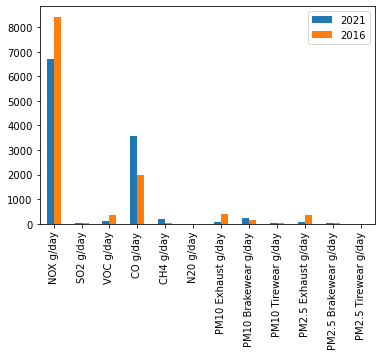

In [105]:
# Summarize Results

# Compare two results by daily emissions rates
fname1 = r'output\2021\python_generated\2021_Port_Onroad_HeavyTrucks_revised.xlsx'
name1 = '2021'

# for port in ['Everett','Seattle','Tacoma']:
#     df1 = pd.read_excel(fname1, sheet_name='Everett')
df1 = pd.read_excel(fname1, sheet_name='Everett')
df1 = df1[['Location']+[i + ' g/day' for i in pollutant_name.values()]]
df1.index = df1['Location']
df1.drop('Location', axis=1, inplace=True)

fname2 = r'output\2016\python_generated\py_2016_Port_Onroad_HeavyTrucks_revised.xlsx'
name2 = '2016'

# for port in ['Everett','Seattle','Tacoma']:
#     df1 = pd.read_excel(fname1, sheet_name='Everett')
df2 = pd.read_excel(fname2, sheet_name='Everett')
df2 = df2[['Location']+[i + ' g/day' for i in pollutant_name.values()]]
df2.index = df2['Location']
df2.drop('Location', axis=1, inplace=True)

pollutant='NOX g/day'
df = df1[[pollutant]].merge(df2[[pollutant]],left_index=True,right_index=True, suffixes=['_'+name1, '_'+name2])


# Summarize by totals of each pollutant
df.sum()


df = pd.DataFrame(df1.sum()).merge(pd.DataFrame(df2.sum()), left_index=True, right_index=True)
df.columns = [name1, name2]
# df.plot(kind='barh')
df.drop(['CO2e g/day','CO2 g/day'], axis=0).plot(kind='bar')

In [ ]:
# Generate summaries from Spreadsheet files